In [14]:
import pandas as pd
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/home/fvalle/phd/master_thesis/")
sys.path.append("/home/fvalle/phd/master_thesis/hsbm/")
from hsbmpy import get_max_available_L

In [15]:
#label = 'disease_type'
algorithm = "topsbm"
directory='/home/fvalle/phd/datasets/merged'
L = get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [16]:
label = 'subset'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,subset,primary_site,dataset
TCGA-E8-A2JQ-11A-11R-A180-07,Thyroid_tcga,Thyroid,tcga
TCGA-EL-A3ZK-11A-11R-A23N-07,Thyroid_tcga,Thyroid,tcga
TCGA-BJ-A28X-11A-11R-A22L-07,Thyroid_tcga,Thyroid,tcga
TCGA-BJ-A28R-11A-11R-A16R-07,Thyroid_tcga,Thyroid,tcga
TCGA-EL-A3T8-11A-11R-A22L-07,Thyroid_tcga,Thyroid,tcga


## Projection based predictions

In [4]:
df_Pst = pd.DataFrame(data=pd.np.matmul(df.values,df_words.values), index= df.index, columns=df_words.columns)
df_Pst = df_Pst.divide(df_Pst.sum(1), 0)
predictions = pd.np.array(list(map(lambda x: list(map(lambda y: entropy(x, y), df_topic_tissue.astype(float).values)), df_Pst.astype(float).values)))

df_Pst.insert(0,'tissue', df_files.reindex(index=df_Pst.index)[label])
reals = pd.np.unique(df_Pst.tissue, return_inverse=True)[1]

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [36]:
print(f"Accuracy projecting score: {accuracy_score(reals, pd.np.argmin(predictions, axis=1))}")

Accuracy projecting score: 0.424


## NN based predictor

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5814013091148605438, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14304621024670728612
 physical_device_desc: "device: XLA_CPU device"]

In [18]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1).divide(df_topics.drop('tissue',1).mean(0),1).values.astype(float)
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

inputs = X_train.shape[1]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

(800, 235) (800, 16) (760, 235) (760, 16)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               23600     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
Total params: 25,216
Trainable params: 25,216
Non-trainable params: 0
_________________________________________________________________
None


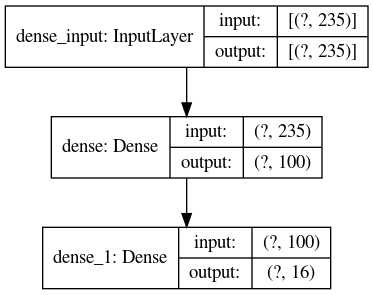

In [33]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=100, input_dim=inputs, use_bias=True, bias_initializer='ones', activation="relu"))
model.add(Dense(units=uniq, input_dim=inputs, activation="sigmoid"))
model.compile(loss=binary_crossentropy, optimizer=SGD(lr=0.1), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, show_shapes=True)

In [34]:
model.fit(X_tm_train, Y_tm_train, epochs=500, batch_size=100, verbose=1, validation_split=0.2, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=12)

Train on 608 samples, validate on 152 samples
Epoch 1/500
608/608 [==============================] - 1s 2ms/sample - loss: 0.9856 - accuracy: 0.7361 - AUC: 0.5315 - val_loss: 0.5322 - val_accuracy: 0.8898 - val_AUC: 0.5906
Epoch 2/500
608/608 [==============================] - 0s 345us/sample - loss: 0.3472 - accuracy: 0.9163 - AUC: 0.6579 - val_loss: 0.4411 - val_accuracy: 0.9145 - val_AUC: 0.6609
Epoch 3/500
608/608 [==============================] - 0s 280us/sample - loss: 0.2680 - accuracy: 0.9312 - AUC: 0.7484 - val_loss: 0.3911 - val_accuracy: 0.9211 - val_AUC: 0.7262
Epoch 4/500
608/608 [==============================] - 0s 315us/sample - loss: 0.2139 - accuracy: 0.9385 - AUC: 0.8179 - val_loss: 0.3717 - val_accuracy: 0.9235 - val_AUC: 0.7648
Epoch 5/500
608/608 [==============================] - 0s 322us/sample - loss: 0.1830 - accuracy: 0.9434 - AUC: 0.8614 - val_loss: 0.3450 - val_accuracy: 0.9289 - val_AUC: 0.7910
Epoch 6/500
608/608 [==============================] - 0s 388

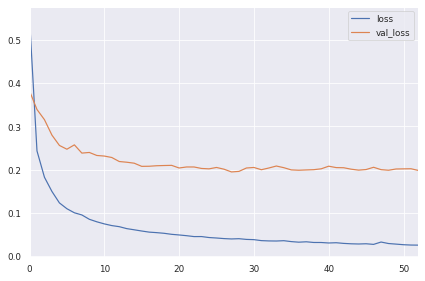

In [21]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [22]:
model.evaluate(X_tm_test, Y_tm_test)

40/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.13192034959793092, 0.965625, 0.9210209]

In [23]:
model.save("model.h5")

In [24]:
gc.collect()

836

# evaluate on non used on topsbm training


In [25]:
df_test_table = pd.read_csv("mainTable_test.csv", index_col = 0)

In [26]:
#get only HV genes
df_test = df_test_table.reindex(index=df_words.index)

df_test = df_test.divide(df_test.sum(0),1).transpose().fillna(0)

df_test = pd.DataFrame(data=np.matmul(df_test.values,df_words.values), index=df_test.index, columns=df_words.columns)
df_test=df_test.divide(df_test.mean(axis=0), axis=1) #normalize P(t|d)
df_test.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 226,Topic 227,Topic 228,Topic 229,Topic 230,Topic 231,Topic 232,Topic 233,Topic 234,Topic 235
TCGA-VN-A88P-01A-11R-A352-07,0.286860,0.006081,0.014705,0.098523,0.020375,0.029710,0.073698,0.360171,0.473814,0.772392,...,0.0,0.000000,0.796637,5.284775,7.241109,0.000000,0.0,0.0,0.008073,0.000000
TCGA-CH-5739-01A-11R-1580-07,0.395807,0.012349,0.036603,0.090145,0.079337,0.118457,0.094612,0.025608,1.106303,0.470970,...,0.0,0.000000,0.833348,0.000000,5.038534,0.586538,0.0,0.0,2.171589,0.545335
TCGA-V1-A9OH-01A-11R-A41O-07,0.340277,0.032712,0.036728,0.014309,0.060879,0.190469,0.020167,0.138148,0.808482,0.424407,...,0.0,0.000000,0.640219,0.000000,0.000000,0.454763,0.0,0.0,0.207530,0.000000
TCGA-EJ-7331-01A-11R-2118-07,0.465609,0.021171,0.013290,0.014640,0.107007,0.134686,0.017426,0.019949,1.052003,0.466466,...,0.0,0.000000,0.000000,0.000000,1.302757,0.000000,0.0,0.0,0.552688,0.255846
TCGA-XK-AAIV-01A-11R-A41O-07,1.007055,0.355887,0.074767,0.087923,0.006790,0.838827,0.284408,0.231949,0.769695,0.723282,...,0.0,4.477105,0.711867,0.000000,0.000000,0.000000,0.0,0.0,0.254764,8.602537


In [27]:
classes = np.unique(df_files.reindex(index=df_test.index)[label])
X_test = df_test.values
Y_test = to_categorical([np.where(classes==t)[0][0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])

In [28]:
model.evaluate(X_test, Y_test, verbose=2, workers=12)

5131/1 - 1s - loss: 0.3117 - accuracy: 0.9518 - AUC: 0.9046


[0.2472743783411146, 0.9517516, 0.9045803]

In [29]:
results = pd.DataFrame(index=classes, columns=classes).fillna(0)

In [30]:
for class_pred, y_test in zip(model.predict_classes(X_test), Y_test):
    results.at[classes[y_test.argmax()], classes[class_pred]]+=1

In [31]:
import seaborn as sns

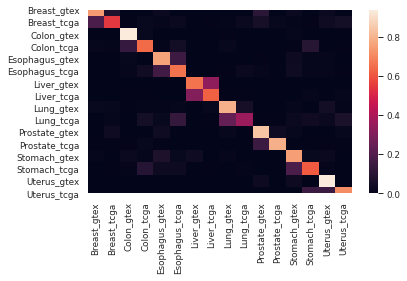

In [32]:
ax = sns.heatmap(results.divide(results.sum(1),0), annot=False)

fig = ax.get_figure()
fig.savefig("predict.pdf")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
tissue='Breast'
df_topic_tissue.transpose().plot(ax=ax[0], marker='o', ms=5)
df_topics[df_topics.index.isin(df_files[df_files['primary_site']==tissue].index)].drop('tissue', 1).transpose().plot(ax=ax[1])
df_topics[df_topics.index.isin(df_files[df_files['primary_site']==tissue].index)].drop('tissue', 1).transpose().mean(1).plot(ax=ax[1], lw=9, ls=':')
ax[1].set_title(tissue)
#ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set_ylim(0,0.8)
ax[1].set_ylim(0,0.8)
plt.show()

In [ ]:
import pickle
from sbmtm import sbmtm

In [ ]:
with open("topsbm/topsbm.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
df_hsbm = pd.DataFrame(index=model.words, columns=model.documents).fillna(0)
for e, count in zip(model.g.get_edges(),model.g.properties[('e', 'count')].get_array()):
    df_hsbm.at[df_hsbm.index[e[1]-1000], df_hsbm.columns[e[0]]]=count

In [ ]:
df_hsbm

In [ ]:
df.reindex(index=df_hsbm.columns, columns=df_hsbm.index).transpose()

In [ ]:
gc.collect()